# Quantified Self  
## 1. Introduction  
The domain for this project is my Google Maps data, specifically my Semantic Location Data. I was interested in doing research on this data because I wanted to see if I have different movement habits during different seasons. Last Spring I studied abroad, and I am curious to see if my movement patterns were different there than they are in Spokane.  

The dataset is in multiple JSON files which are seperated by month. The tables that I am inclding from the dataset are ...... The data in each table is collected....There are .. instances.  

* Study abroad dates: jan 21 2022 - may 5 2022 (excluding days at the airport)
* Spokane sample (summer): May 22 2022 - Aug 14 2022
* Spokane sample (school year): 
* Spokane pandemic: 
## 2. Data Analysis
### I. Data Loading  
The first step is to load the data from JSON format into two Pandas dataframes--one for my time studying abroad in Spain, and one for my Summer in Spokane. 

I used [`pd.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to combine the different months.

##### *notes: use pd.to_datetime, use "format" if needed. make new col (df_date = date_list), where datelist uses for loop to get all dates (datelist.append(d.date)),also make graphs

In [1673]:
import pandas as pd
import utils 
import importlib
importlib.reload(utils) # to reload utils every time

jan_aug_df = pd.DataFrame()

months = ["JANUARY", "FEBRUARY", "MARCH", "APRIL", "MAY", "JUNE", "JULY", "AUGUST"]
for item in months:
    jan_aug_df = pd.concat([jan_aug_df, pd.read_json("../Semantic Location History/2022/2022_" + item + ".json")])

#send to new json file
jan_aug_df.to_csv("jan_to_aug.csv")

### II. Data cleaning
In this section, I will clean my Google Maps Semantic Location Data and send it to a csv file that will have meaningful column headers and only contains the information we want. First, lets get the data that we want from JSON format to a 2D list. (Later on I will use this 2D list to create a Pandas Dataframe).

Now that the data for the months we need is all in one spot, we can grab chunks that we need more easily. 

In [1648]:
print(type(jan_aug_df["timelineObjects"].iloc[0]))

# this is json data (dictionary)

<class 'dict'>


Before we get to hypothesis testing, lets change some of the categorical values to numeric using the `sklearn.preprocessing.LabelEncoder()`.

In [1649]:
# make copies of dfs
jan_aug_df_num = jan_aug_df.copy()


In [1666]:
# need to grab dates from 2022-01-21 to 2022-01-31, 2022-02-xx, 2022-03-xx, 2022-04-xx, and through 2022-05-05

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

print(jan_aug_df.size)
# for i in range(jan_aug_df.size):
#     for key, val in jan_aug_df["timelineObjects"].iloc[i].items():
#         # get only activity segments (not place visits)
#         if(key == "activitySegment"):
#             #print(val["duration"]["startTimestamp"])
#             if "2022-01-21" in val["duration"]["startTimestamp"]:
#                 print(i)
#                 print(val["duration"]["startTimestamp"])
#             elif "2022-05-05" in val["duration"]["startTimestamp"]:
#                 print(i)
#                 print(val["duration"]["startTimestamp"])
# start index : 118
# end index : 1333


start = 118
end = 1333

#timestamps = []
study_abroad_lst = []
for i in range(start, end):
    for key, val in jan_aug_df["timelineObjects"].iloc[i].items():
        # get only activity segments (not place visits)
        if(key == "activitySegment"):
            #timestamps.append(val["duration"]["startTimestamp"])
            #print(val["activityType"])
            #print(val["confidence"])
            #print(val["distance"])
            study_abroad_lst.append([val["duration"]["startTimestamp"], val["duration"]["endTimestamp"], val["startLocation"]["latitudeE7"], val["startLocation"]["longitudeE7"], val["endLocation"]["latitudeE7"], val["endLocation"]["longitudeE7"], val["distance"], val["activityType"], val["confidence"]])

study_abroad_df = pd.DataFrame(study_abroad_lst, columns=["Start Timestamp", "End Timestamp", "Start Latitude", "Start Longitude", "End Latitude", "End Longitude", "Distance", "Activity", "Confidence"])

start_fixed = pd.to_datetime(study_abroad_df["Start Timestamp"])
end_fixed = pd.to_datetime(study_abroad_df["End Timestamp"])

study_abroad_df["Start Timestamp"] = start_fixed
study_abroad_df["End Timestamp"] = end_fixed

study_abroad_df

2357


,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING,HIGH
1,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING,HIGH
2,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING,HIGH
3,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING,HIGH
4,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...
637,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY,HIGH
638,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING,LOW
640,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY,LOW


Lets parse the timestamps for just the date.

In [1667]:
date_lst = []
for item in study_abroad_df["Start Timestamp"]:
    date_lst.append((item.date().strftime("%Y-%m-%d")))
date_lst

# add col
study_abroad_df.insert(column="Date", value=date_lst, loc=0)
study_abroad_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING,HIGH
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING,HIGH
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING,HIGH
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING,HIGH
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY,HIGH
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING,LOW
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY,LOW


In [1652]:
# get summer data- 2022-05-22 through 2022-08-14
# for i in range(jan_aug_df.size):
#     for key, val in jan_aug_df["timelineObjects"].iloc[i].items():
#         # get only activity segments (not place visits)
#         if(key == "activitySegment"):
#             #print(val["duration"]["startTimestamp"])
#             if "2022-05-22" in val["duration"]["startTimestamp"]:
#                 print(i)
#                 print(val["duration"]["startTimestamp"])
#             elif "2022-08-14" in val["duration"]["startTimestamp"]:
#                 print(i)
#                 print(val["duration"]["startTimestamp"])
start = 1491
end = 2216

summer_lst = []
for i in range(start, end):
    for key, val in jan_aug_df["timelineObjects"].iloc[i].items():
        # get only activity segments (not place visits)
        if(key == "activitySegment"):
            #timestamps.append(val["duration"]["startTimestamp"])
            #print(val["activityType"])
            #print(val["confidence"])
            #print(val["distance"])
            summer_lst.append([val["duration"]["startTimestamp"], val["duration"]["endTimestamp"], val["startLocation"]["latitudeE7"], val["startLocation"]["longitudeE7"], val["endLocation"]["latitudeE7"], val["endLocation"]["longitudeE7"], val["distance"], val["activityType"], val["confidence"]])


summer_df = pd.DataFrame(summer_lst, columns=["Start Timestamp", "End Timestamp", "Start Latitude", "Start Longitude", "End Latitude", "End Longitude", "Distance", "Activity", "Confidence"])

start_fixed = pd.to_datetime(summer_df["Start Timestamp"])
end_fixed = pd.to_datetime(summer_df["End Timestamp"])

summer_df["Start Timestamp"] = start_fixed
summer_df["End Timestamp"] = end_fixed

summer_df


,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE,HIGH
1,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE,HIGH
2,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE,HIGH
3,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE,HIGH
4,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...
358,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE,HIGH
359,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE,HIGH
360,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE,HIGH
361,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE,HIGH


##### fix Latitude and Longitude Columns  

In [1676]:
fixed_start_lat_lst = utils.fix_lat_lon(study_abroad_df, "Start Latitude", 2)
study_abroad_df["Start Latitude"] = fixed_start_lat_lst

fixed_start_lon_lst = utils.fix_lat_lon(study_abroad_df, "Start Longitude", 1)
study_abroad_df["Start Longitude"] = fixed_start_lon_lst

fixed_end_lat_lst = utils.fix_lat_lon(study_abroad_df, "End Latitude", 2)
study_abroad_df["End Latitude"] = fixed_end_lat_lst

fixed_end_lon_lst = utils.fix_lat_lon(study_abroad_df, "End Longitude", 1)
study_abroad_df["End Longitude"] = fixed_end_lon_lst
study_abroad_df
study_abroad_df.to_csv("study_abroad.csv")

#spokane
fixed_start_lat_lst = utils.fix_lat_lon(summer_df, "Start Latitude", 2)
summer_df["Start Latitude"] = fixed_start_lat_lst

fixed_start_lon_lst = utils.fix_lat_lon(summer_df, "Start Longitude", 3)
summer_df["Start Longitude"] = fixed_start_lon_lst

fixed_end_lat_lst = utils.fix_lat_lon(summer_df, "End Latitude", 2)
summer_df["End Latitude"] = fixed_end_lat_lst

fixed_end_lon_lst = utils.fix_lat_lon(summer_df, "End Longitude", 3)
summer_df["End Longitude"] = fixed_end_lon_lst
summer_df.to_csv("summer_spokane.csv")


Now I will join my dataframes with weather data using the Meteostat API. I will use the "Date" column and the "Start Latitude" and "Start Latitude" columns in order to get the nearest weather station. first lets initialize my API key and headers.

In [1654]:
import config
import requests
import json

my_ms_key = config.key["x-rapidapi-key"]

headers = { 'x-rapidapi-host': 'meteostat.p.rapidapi.com',
                    "x-rapidapi-key" : my_ms_key }
#make url for madrid
url = utils.make_weather_st_url("40.4168", "-3.7038")

response = requests.get(url=url, headers=headers)

# load results into json format
meteo_stat_json_obj = json.loads(response.text)
# get the station id
weather_station_id = utils.get_station_id(meteo_stat_json_obj)
print(weather_station_id)


08222


In [1674]:
# make url to get daily weather
daily_weather_url = utils.make_daily_weather_url(weather_station_id)
# request daily weather data
response = requests.get(url=daily_weather_url, headers=headers)
#put weather data int json format
daily_weather_json = json.loads(response.text)

# get 2d list of daily weather data from json file
daily_weather_2D_lst = utils.load_2d_list(daily_weather_json)
# make cleaner headers
daily_weather_headers = ["Date", "Avg Temp", "Min Temp", "Max Temp", "Precip.", "Snow", "Wind Dir.", "Wind Speed", "Peak Wind Gust", "Pressure", "Total Sun"]
# make dataframe from headers and 2d list of data
weather_df = pd.DataFrame(daily_weather_2D_lst, columns=daily_weather_headers)
weather_df

,Date,Avg Temp,Min Temp,Max Temp,Precip.,Snow,Wind Dir.,Wind Speed,Peak Wind Gust,Pressure,Total Sun
0,2022-01-21,40.8,33.8,48.0,0.000,None,32.0,6.6,None,1027.9,None
1,2022-01-22,41.0,34.2,48.7,0.000,None,37.0,6.5,None,1030.8,None
2,2022-01-23,42.4,36.3,48.7,0.000,None,49.0,5.3,None,1028.1,None
3,2022-01-24,43.9,39.2,47.3,0.000,None,40.0,4.9,None,1028.8,None
4,2022-01-25,46.2,39.7,50.7,0.000,None,62.0,5.5,None,1031.7,None
...,...,...,...,...,...,...,...,...,...,...,...
100,2022-05-01,62.4,55.2,77.9,0.000,None,321.0,4.7,None,1017.8,None
101,2022-05-02,57.6,53.6,66.9,0.087,None,8.0,6.5,None,1011.2,None
102,2022-05-03,55.9,52.0,63.5,0.102,None,50.0,10.8,None,1011.8,None
103,2022-05-04,57.7,50.4,68.4,0.000,None,42.0,9.8,None,1016.1,None


In [1677]:
merged_df = study_abroad_df.merge(weather_df, how='inner', on="Date")
merged_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence,Avg Temp,Min Temp,Max Temp,Precip.,Snow,Wind Dir.,Wind Speed,Peak Wind Gust,Pressure,Total Sun
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,HIGH,40.8,33.8,48.0,0.0,None,32.0,6.6,None,1027.9,None
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,HIGH,40.8,33.8,48.0,0.0,None,32.0,6.6,None,1027.9,None
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,HIGH,40.8,33.8,48.0,0.0,None,32.0,6.6,None,1027.9,None
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,HIGH,40.8,33.8,48.0,0.0,None,32.0,6.6,None,1027.9,None
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,HIGH,40.8,33.8,48.0,0.0,None,32.0,6.6,None,1027.9,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,HIGH,58.8,51.1,74.1,0.0,None,27.0,5.4,None,1021.3,None
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,MEDIUM,58.8,51.1,74.1,0.0,None,27.0,5.4,None,1021.3,None
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,LOW,58.8,51.1,74.1,0.0,None,27.0,5.4,None,1021.3,None
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,LOW,58.8,51.1,74.1,0.0,None,27.0,5.4,None,1021.3,None


### IV. Hypothesis Testing  
#### Test 1: Two Sample One Tailed Independent T Test of Mean Distance of Activity Segments 
* using my Google Maps dataset, I am going to see if the mean distance of my activity segments in Spain was smaller than the mean distance of my activity segments in Spokane over the Summer.
* my significance level $\alpha$ will be 0.05.

Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [1655]:
# n for both samples:
sa_n = study_abroad_df["Distance"].size
print(sa_n)

sum_n = summer_df["Distance"].size
print(sum_n)
df = sa_n + sum_n - 2
print("Degrees of freedom is", df)

642
363
Degrees of freedom is 1003


**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{Spain} \geq \mu_{Spokane}$   
$H_1$  : $\mu_{Spain} < \mu_{Spokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [1656]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

In [1657]:
t_crit = -1.6469

**Step 4: formulate the _decision rule_**

If $t_{computed} \geq$ 1.6469, do not reject $H_{0}$-->The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.   
If $t_{computed} <$ 1.6469, reject $H_{0}$-->The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [1658]:
from scipy import stats

# get t and pvalue
t_comp, p_val = stats.ttest_ind(study_abroad_df["Distance"], summer_df["Distance"])
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean distance of activity segments in Spain is less than the population mean distance of activity segments in Spokane")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is greater than or equal to the population mean distance of activity segments in Spokane.")

T is -0.5531 , and p-value is 0.2901
Do not reject H0. The population mean distance of activity segments in Spain is greater than or equal to the population mean distance of activity segments in Spokane.


#### Test 2: Two Sample One-tailed Independent T Test of Mean Travel Activity  
* here I will be testing the mean travel activity between Spain and Spokane
* I will need to change the categorical travel activity data to numerical data using `sklearn.preprocessing.LabelEncoder()`.
* lets concatenate the two dataframes first for consistent encoding

In [1659]:
combined_df = pd.concat([study_abroad_df, summer_df])

In [1660]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()

X = combined_df
le.fit(X["Activity"])
list(le.classes_)
arr = le.transform(X["Activity"])

X["Activity"] = arr
X.to_csv("test.csv")
#print(X.iloc[641])

study_abroad_act_num = []
summer_act_num = []
#add to original dfs
for i in range(642):
    study_abroad_act_num.append(X["Activity"].iloc[i])
for i in range(642, X["Activity"].size):
    summer_act_num.append(X["Activity"].iloc[i])

# replace original activity cols
study_abroad_df["Activity"] = study_abroad_act_num
summer_df["Activity"] = summer_act_num


TypeError: 'list' object is not callable

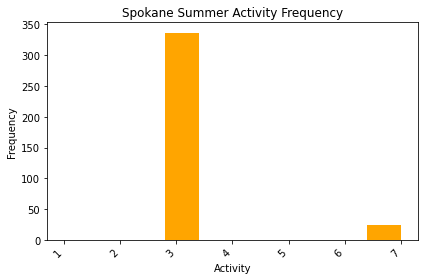

In [ ]:
import matplotlib.pyplot as plt

# labels
plt.xticks(rotation=45, ha="right") # ha: horizontal alignment
plt.title("Spokane Summer Activity Frequency")
plt.xlabel("Activity")
plt.ylabel("Frequency")

# plot 
plt.hist(summer_df["Activity"], color="orange")
plt.tight_layout()
plt.show()

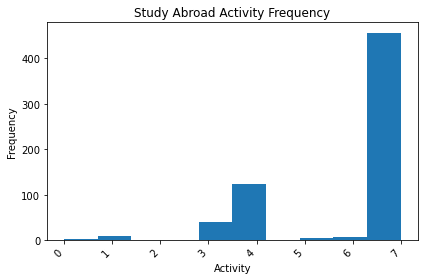

In [ ]:
# new figure
plt.figure()

# labels
plt.xticks(rotation=45, ha="right") # ha: horizontal alignment
plt.title("Study Abroad Activity Frequency")
plt.xlabel("Activity")
plt.ylabel("Frequency")

# plot 
plt.hist(study_abroad_df["Activity"])
plt.tight_layout()
plt.show()



Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [ ]:

df = 1003
print("Degrees of freedom is", df)

Degrees of freedom is 1003


In Bus = 1, In Ferry = 2, In Passenger Vehicle = 3, In Subway = 4, In Train = 5, Unknown = 6, Walking = 7

**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{ActivitySpain} \leq \mu_{ActivitySpokane}$   
$H_1$  : $\mu_{ActivitySpain} > \mu_{ActivitySpokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [ ]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

**Step 4: formulate the _decision rule_**

If $t_{computed} \leq$ 1.6469, do not reject $H_{0}$-->The population mean activity type in Spain is less than or equal to the population mean activity type in Spokane.  
If $t_{computed} >$ 1.6469, reject $H_{0}$-->The population mean activity type in Spain is greater than the population mean activity type in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [ ]:
# get t and pvalue
t_comp, p_val = stats.ttest_ind(study_abroad_df["Activity"], summer_df["Activity"])
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is greater than or equal to the population mean distance of activity segments in Spokane.")

T is 29.9115 , and p-value is 0.0000
Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.


## 3. Machine Learning  
In this section I will classify the data using the kNN algorithm and a Decision Tree Classiie.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier